In [5]:
import numpy as np
import os
os.chdir("..")

from helpers import *
from helpers_perso import *
from nan_imputation import *
from one_hot_encoding import *
from implementations import *
from standardization import *
from class_balancing import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data

In [3]:
data_path = os.path.join(os.getcwd(), "data", "dataset")
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path)
print("Data loaded successfully!")


Data loaded successfully!


## Variance across columns

In [ ]:
import matplotlib.pyplot as plt

column_variances = np.nanvar(x_train, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Full range of variances with more bins
axes[0].hist(column_variances, bins=100, edgecolor='black')
axes[0].set_title("Distribution of Variance Across Columns (Full Range)")
axes[0].set_xlabel("Variance")
axes[0].set_ylabel("Frequency")

# Second subplot: Focus on variance between 0 and 0.5
axes[1].hist(column_variances, bins=20, range=(0, 1000), edgecolor='black')
axes[1].set_title("Distribution of Variance Across Columns (0 to 1000)")
axes[1].set_xlabel("Variance")
axes[1].set_ylabel("Frequency")

# Third subplot: Focus on variance between 1 and 200
axes[2].hist(column_variances, bins=100, range=(1, 200), edgecolor='black')
axes[2].set_title("Distribution of Variance Across Columns (1 to 200)")
axes[2].set_xlabel("Variance")
axes[2].set_ylabel("Frequency")

# Display the plots
plt.tight_layout()
plt.show()

## Balancing the data

Total number of columns plotted: 299160
Number of columns containing NaN values: 299160


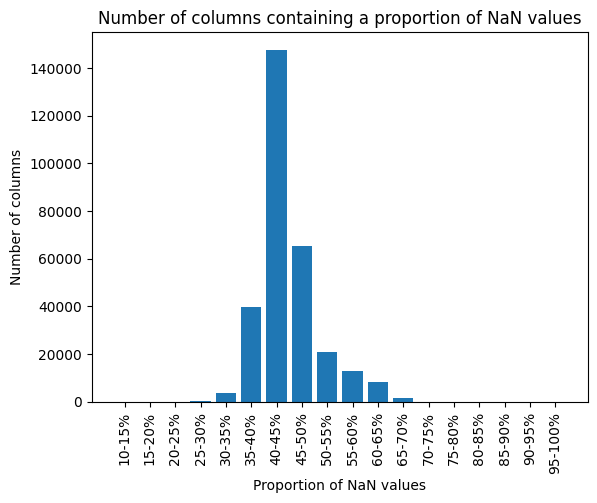

In [4]:
import matplotlib.pyplot as plt

class1_ids = np.where(y_train == -1)[0]

x_train_majority_class = x_train[class1_ids]

# Calculate the proportion of NaN values in each column
nan_proportions = np.isnan(x_train_majority_class).mean(axis=1)

# Print the total number of columns plotted
total_columns = nan_proportions.size
print(f"Total number of columns plotted: {total_columns}")

# Print the number of columns containing NaN values
num_columns_with_nans = np.sum(nan_proportions > 0)
print(f"Number of columns containing NaN values: {num_columns_with_nans}")

# Define the bins for the histogram
bins = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

# Calculate the histogram
hist, bin_edges = np.histogram(nan_proportions, bins=bins)

# Create the bar plot
plt.bar(range(len(hist)), hist, tick_label=[f'{int(b*100)}-{int(bins[i+1]*100)}%' for i, b in enumerate(bins[:-1])])
plt.xlabel('Proportion of NaN values')
plt.ylabel('Number of columns')
plt.title('Number of columns containing a proportion of NaN values')

# Rotate the x-axis tick labels to vertical
plt.xticks(rotation=90)

plt.show()

In [11]:
print(x_train.shape)
x_balanced, y_balanced, deleted_ids = balance_classes(x_train, y_train, 1)
print(x_balanced.shape)

(328135, 321)
(57950, 321)


## Handling columns containing Nan

Proportion of Nan values in Nan-containing values

In [ ]:
import matplotlib.pyplot as plt

# Calculate the proportion of NaN values in each column
nan_proportions = np.isnan(x_train).mean(axis=0)

# Print the total number of columns plotted
total_columns = nan_proportions.size
print(f"Total number of columns plotted: {total_columns}")

# Print the number of columns containing NaN values
num_columns_with_nans = np.sum(nan_proportions > 0)
print(f"Number of columns containing NaN values: {num_columns_with_nans}")

# Define the bins for the histogram
bins = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

# Calculate the histogram
hist, bin_edges = np.histogram(nan_proportions, bins=bins)

# Create the bar plot
plt.bar(range(len(hist)), hist, tick_label=[f'{int(b*100)}-{int(bins[i+1]*100)}%' for i, b in enumerate(bins[:-1])])
plt.xlabel('Proportion of NaN values')
plt.ylabel('Number of columns')
plt.title('Number of columns containing a proportion of NaN values')

# Rotate the x-axis tick labels to vertical
plt.xticks(rotation=90)

plt.show()

Thus not reasonnable to exclude columns containing Nan values
Choice : remove columns with Nan proportion superior to 80 % ?

In [12]:
# Clean all arrays by removing columns containing NaN values
x_train_cleaned, deleted_indices = remove_nan_features(x_balanced, 0.8)

adapted_x_test = np.delete(x_train, deleted_indices, axis=1)


Percentage of columns to delete (NaN proportion superior to 80.0 %): 38.32%
Data cleaned successfully!
Original shape of x_train: (57950, 321)
Cleaned shape of x_train: (57950, 198)


In [13]:
integer_columns, non_integer_columns = identify_integer_columns(x_train_cleaned)

assert len(integer_columns) + len(non_integer_columns) == x_train_cleaned.shape[1]


# Print the integer columns
print(f"Number of columns containing only integer values: {len(integer_columns)}")

# Count the number of columns in integer_columns that contain at least one zero
num_columns_with_zero = sum(np.any(x_train_cleaned[:, col] == 0) for col in integer_columns)

# Print the result
print(f"Percentage of integer columns that contain at least one zero: {num_columns_with_zero/len(integer_columns)*100:.2f}%")    

Number of columns containing only integer values: 176
Percentage of integer columns that contain at least one zero: 13.64%


(If only contains integers and no zeroes (=encoded), encode Nan as 0)

In [14]:
x_train_cleaned_without_nans = encode_nan_integer_columns(x_train_cleaned, replacement_value='mode')
x_train_cleaned_without_nans = encode_nan_continuous_columns(x_train_cleaned_without_nans, replacement_value='mode')

assert np.isnan(x_train_cleaned_without_nans).sum() == 0
assert x_train_cleaned.shape == x_train_cleaned_without_nans.shape

adapted_x_test_without_nans = encode_nan_integer_columns(adapted_x_test, replacement_value='mode')
adapted_x_test_without_nans = encode_nan_continuous_columns(adapted_x_test_without_nans, replacement_value='mode')

assert np.isnan(adapted_x_test_without_nans).sum() == 0
assert adapted_x_test.shape == adapted_x_test_without_nans.shape

Column 9 has been encoded with NaNs as the mode 1.0
Column 10 has been encoded with NaNs as the mode 1.0
Column 11 has been encoded with NaNs as the mode 1.0
Column 12 has been encoded with NaNs as the mode 2.0
Column 13 has been encoded with NaNs as the mode 2.0
Column 14 has been encoded with NaNs as the mode 1.0
Column 15 has been encoded with NaNs as the mode 1.0
Column 16 has been encoded with NaNs as the mode 1.0
Column 17 has been encoded with NaNs as the mode 1.0
Column 18 has been encoded with NaNs as the mode 1.0
Column 19 has been encoded with NaNs as the mode 1.0
Column 20 has been encoded with NaNs as the mode 1.0
Column 21 has been encoded with NaNs as the mode 2.0
Column 22 has been encoded with NaNs as the mode 2.0
Column 24 has been encoded with NaNs as the mode 88.0
Column 26 has been encoded with NaNs as the mode 88.0
Column 31 has been encoded with NaNs as the mode 1.0
Column 32 has been encoded with NaNs as the mode 1.0
Column 34 has been encoded with NaNs as the m

In [ ]:
# Calculate the number of columns that do not contain only integer values
num_non_integer_columns = len(non_integer_columns)

# Print the result
print(f"Number of columns that do not contain only integer values: {num_non_integer_columns}")

## One-hot encoding

In columns containing only integer values, number of unique values

In [ ]:
import matplotlib.pyplot as plt

unique_value_counts = np.array([len(np.unique(x_train_cleaned[:, col])) for col in integer_columns])

# Create 20 bins based on the range of unique value counts
max_unique = unique_value_counts.max() if unique_value_counts.size > 0 else 0
bins = np.linspace(0, max_unique, 21)  # 21 edges for 20 bins
bin_labels = [f'{int(b)}-{int(bins[i+1])}' for i, b in enumerate(bins[:-1])]

# Count how many columns fall into each bin
binned_counts = np.histogram(unique_value_counts, bins=bins)[0]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, binned_counts, width=0.6, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Unique Values in Columns')
plt.ylabel('Number of Columns')
plt.title('Columns Grouped by Number of Unique Values (20 Bins)')
plt.xticks(rotation=45)
plt.tight_layout()
# Create the second set of bins for values between 2000 and 0
bins_2000 = np.linspace(0, 2000, 21)  # 21 edges for 20 bins
bin_labels_2000 = [f'{int(b)}-{int(bins_2000[i+1])}' for i, b in enumerate(bins_2000[:-1])]

# Count how many columns fall into each bin for the second set of bins
binned_counts_2000 = np.histogram(unique_value_counts, bins=bins_2000)[0]

# Create the second bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_labels_2000, binned_counts_2000, width=0.6, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Unique Values in Columns (0-2000)')
plt.ylabel('Number of Columns')
plt.title('Columns Grouped by Number of Unique Values (20 Bins, 0-2000)')
plt.xticks(rotation=45)
plt.tight_layout()

# Create the third set of bins for values between 0 and 100
bins_100 = np.linspace(0, 100, 21)  # 21 edges for 20 bins
bin_labels_100 = [f'{int(b)}-{int(bins_100[i+1])}' for i, b in enumerate(bins_100[:-1])]

# Count how many columns fall into each bin for the third set of bins
binned_counts_100 = np.histogram(unique_value_counts, bins=bins_100)[0]

# Create the third bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_labels_100, binned_counts_100, width=0.6, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Unique Values in Columns (0-100)')
plt.ylabel('Number of Columns')
plt.title('Columns Grouped by Number of Unique Values (20 Bins, 0-100)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Given number of unique value mainly in 0-5 range, lets say it's categorical if in this range

In [15]:
categorical_threshold = 5

# Step 1: Compute unique value counts for each integer column
unique_value_counts = np.array([len(np.unique(x_train_cleaned[:, col])) for col in integer_columns])

# Step 2: Identify categorical and non-categorical features based on the threshold
indexes_categorical_features = [integer_columns[i] for i, count in enumerate(unique_value_counts) if count <= categorical_threshold]
indexes_non_categorical_features = [integer_columns[i] for i in range(len(unique_value_counts)) if integer_columns[i] not in indexes_categorical_features]

assert len(indexes_categorical_features) + len(indexes_non_categorical_features) == len(unique_value_counts)
assert unique_value_counts.size == len(integer_columns)

indexes_non_categorical_features.extend(non_integer_columns)


## Standardization

In [16]:
# x_standardized = standardize_columns(x_train_cleaned_without_nans, range(x_train_cleaned_without_nans.shape[1]))

x_standardized = standardize_columns(x_train_cleaned_without_nans, indexes_non_categorical_features)

x_test_standardized = standardize_columns(adapted_x_test_without_nans, indexes_non_categorical_features)

Binary encoding

In [17]:
# encoded_x_train = binary_encode_columns(x_standardized, indexes_categorical_features)

encoded_x_train, encoded_x_test = consistent_binary_encode(x_standardized, x_test_standardized, indexes_categorical_features)

In [48]:
print(encoded_x_train.shape)
print(encoded_x_test.shape)

(328135, 291)
(109379, 291)


## Finding best parameters


In [19]:
# X_ici = x_train_cleaned_without_nans
# X_ici = standardize_columns(X_ici, indexes_non_categorical_features)

X_ici = encoded_x_train

# # X_ici = x_train_cleaned





y_ici = y_balanced

# linear regression
initial_w = np.zeros(X_ici.shape[1])
max_iters = 30
gamma = 0.01
# print (least_squares(y_ici, X_ici))
w, loss = mean_squared_error_gd(y_ici, X_ici, initial_w, max_iters, gamma)

# percentages_to_drop = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# nan_values_for_integer_columns = ['mode', 'upper', 'zero']
# nan_values_for_continuous_columns = ['mean', 'mode', 'zero']



GD iter. 0/29: loss=0.411574884174237, w0=0.0006711786372023837, w1=1.0569240309692936e-05
GD iter. 1/29: loss=0.34742526293121956, w0=0.0012441114178673258, w1=1.8659283859127778e-05
GD iter. 2/29: loss=0.29972177082614, w0=0.0017343091545413821, w1=2.4762496006059245e-05
GD iter. 3/29: loss=0.2637348458667354, w0=0.0021543901677631996, w1=2.922805948748565e-05
GD iter. 4/29: loss=0.2363467558911276, w0=0.002514779696843118, w1=3.23104598307265e-05
GD iter. 5/29: loss=0.2153753777948221, w0=0.002824196554420451, w1=3.420045385568465e-05
GD iter. 6/29: loss=0.19923672895424477, w0=0.0030900006702291455, w1=3.5045024971679774e-05
GD iter. 7/29: loss=0.18675707702395206, w0=0.003318448235951653, w1=3.496038859151253e-05
GD iter. 8/29: loss=0.177056873792088, w0=0.0035148842837229737, w1=3.404058984741557e-05
GD iter. 9/29: loss=0.1694730169173301, w0=0.0036838919251914373, w1=3.2363287165312276e-05
GD iter. 10/29: loss=0.16350391170594702, w0=0.003829410790630601, w1=2.9993723250151933e-

In [50]:
from predict_labels import *
# adapted_x_test = np.delete(x_test, deleted_indices, axis=1)
# standardized_x_test = standardize_columns(adapted_x_test, indexes_non_categorical_features)
# encoded_x_test = binary_encode_columns(adapted_x_test, indexes_categorical_features)
# print(standardized_x_test.shape)
# print(x_standardized.shape)

# print(encoded_x_test.shape)
# print(encoded_x_train.shape)
y_test = predict_classification(encoded_x_test,w)
print(y_test)

[-1 -1 -1 ... -1 -1 -1]


percentage of Nan to drop

In [ ]:
best_loss = np.inf
best_percentage_to_drop = None
best_nan_value_for_integer_columns = None
best_nan_value_for_continuous_columns = None

for percentage_to_drop in percentages_to_drop:
    for nan_value_for_continuous_columns in nan_values_for_continuous_columns:
        for nan_value_for_integer_columns in nan_values_for_integer_columns:
    
            x_train_cleaned = remove_nan_features(x_train, percentage_to_drop)

            x_train_cleaned_without_nans = encode_nan_integer_columns(x_train_cleaned, replacement_value=nan_value_for_integer_columns)
            x_train_cleaned_without_nans = encode_nan_continuous_columns(x_train_cleaned_without_nans, replacement_value=nan_value_for_continuous_columns)

            assert np.isnan(x_train_cleaned_without_nans).sum() == 0
            assert x_train_cleaned.shape == x_train_cleaned_without_nans.shape

            x_standardized = standardize_columns(x_train_cleaned_without_nans, range(x_train_cleaned_without_nans.shape[1]))

            initial_w = np.zeros(X_ici.shape[1])
            max_iters = 100
            gamma = 0.01

            w, loss = mean_squared_error_gd(y_ici, X_ici, initial_w, max_iters, gamma)

            if loss < best_loss:
                best_loss = loss
                best_percentage_to_drop = percentage_to_drop
                best_nan_value_for_integer_columns = nan_value_for_integer_columns
                best_nan_value_for_continuous_columns = nan_value_for_continuous_columns

print(f"Best loss: {best_loss}")    
print(f"Best percentage to drop: {best_percentage_to_drop}")
print(f"Best nan value for integer columns: {best_nan_value_for_integer_columns}")
print(f"Best nan value for continuous columns: {best_nan_value_for_continuous_columns}")
    
    